## Import the packages

In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.1 MB/s eta 0:00:00
zsh:1: no matches found: gymnasium[box2d]


In [2]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
env_id = "CartPole-v1"
#env_id="LunarLander-v2"
# Create the env
env = gym.make(env_id)


# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [5]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):

        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [6]:
#Using a neural network to learn state value
class Critic(nn.Module):

    #Takes in state
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()

        # two fully connected layers
        self.input_layer = nn.Linear(s_size, h_size)
        self.output_layer = nn.Linear(h_size, 1)

    def forward(self, x):

        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [7]:
 def generate_trajectory(actor, critic, max_t):
        saved_log_probs = []
        rewards = []
        state_values=[]

        state, _ = env.reset()
        for t in range(max_t):
            state=torch.from_numpy(state).float().unsqueeze(0).to(device)

            action, log_prob = actor.act(state)



            # get the state value from th critic network
            state_val= critic(state)


            next_state, reward, done,truncated , _ = env.step(action)

            # add te obtained results to their relative lists ==> saved_log_probs, rewards, state_values
            rewards.append(reward)
            saved_log_probs.append(log_prob)
            state_values.append(state_val)
            # add code here
            # add code here
            # add code here

            state=next_state

            if done:

                break

        return  saved_log_probs, rewards, state_values

In [8]:
def computer_cumulative_reward(rewards, max_t,gamma):

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
          disc_return_t = (returns[0] if len(returns)>0 else 0)
          returns.appendleft( rewards[t]+gamma*disc_return_t)
        return returns

In [9]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

In [10]:

def train_actor(actorOptimizer,saved_log_probs, returns,state_values):


        state_values= torch.stack(state_values).squeeze()

        #calculate Advantage for actor
        advantages = returns - state_values.detach()

        #convect the advantages to a tensor
        advantages = torch.tensor(advantages).to(device)

        actor_loss = []
        # compute the actor loss
        for log_prob, advantage in zip(saved_log_probs, advantages):
            actor_loss.append(-log_prob * advantage)


        actor_loss = torch.cat(actor_loss).sum()
        # Backpropagate actor
        actorOptimizer.zero_grad()
        actor_loss.backward()
        actorOptimizer.step()


In [11]:

def train_critic(criticOptimizer, returns,state_values):
        state_values= torch.stack(state_values).squeeze()

        critic_loss=F.mse_loss(state_values,returns)

        # Backpropagate crtic
        criticOptimizer.zero_grad()
        critic_loss.backward()
        criticOptimizer.step()

In [12]:
def Actor_Critic(actor,critic, actorOptimizer,criticOptimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):

        # Generate an episode
        saved_log_probs, rewards, state_values = generate_trajectory(actor, critic, max_t)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # calculate the return
        returns= computer_cumulative_reward(rewards,max_t,gamma)

        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)

        # Train the Critic network
        train_critic(criticOptimizer, returns,state_values)
        #add code here

        # Train the Actor network
        train_actor(actorOptimizer,saved_log_probs, returns,state_values)
        #add code here



        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [13]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [14]:
# Create actor and place it to the device
cartpole_actor = Actor(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)

cartpole_actorOptimizer = optim.Adam(cartpole_actor.parameters(), lr=cartpole_hyperparameters["lr"])

In [15]:
# Create critic and place it to the device
cartpole_critic = Critic(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_criticOptimizer = optim.Adam(cartpole_critic.parameters(), lr=cartpole_hyperparameters["lr"])

In [16]:
scores = Actor_Critic(cartpole_actor,
                   cartpole_critic,cartpole_actorOptimizer,cartpole_criticOptimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

/var/folders/f3/fnztj0dx7v58nbvbmkwh7df80000gn/T/ipykernel_2575/3061804092.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages = torch.tensor(advantages).to(device)


Episode 100	Average Score: 103.18
Episode 200	Average Score: 653.24
Episode 300	Average Score: 976.14
Episode 400	Average Score: 1000.00
Episode 500	Average Score: 1000.00
Episode 600	Average Score: 872.99
Episode 700	Average Score: 990.93
Episode 800	Average Score: 974.85
Episode 900	Average Score: 1000.00
Episode 1000	Average Score: 997.61


In [18]:
scores= pd.Series(scores, name="scores_Actor")
scores.describe()

count    1000.000000
mean      856.894000
std       310.930472
min        11.000000
25%      1000.000000
50%      1000.000000
75%      1000.000000
max      1000.000000
Name: scores_Actor, dtype: float64

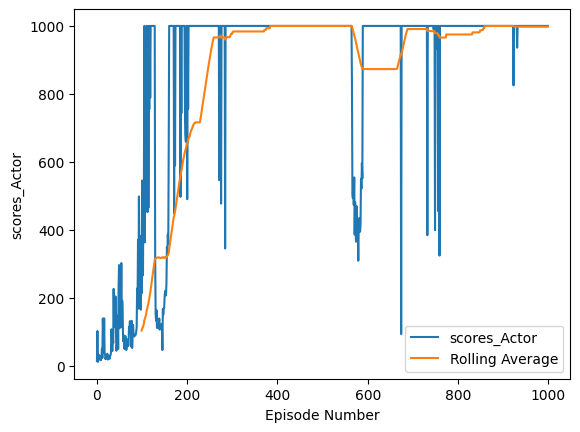

In [19]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_Actor")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")

In [20]:
def evaluate_agent(actor, env, n_eval_episodes, max_t):
  """Evaluates the agent's performance.

  Args:
    actor: The trained actor network.
    env: The Gym environment.
    n_eval_episodes: The number of episodes to run for evaluation.
    max_t: The maximum number of steps per episode.

  Returns:
    A tuple containing the average reward and the average number of steps.
  """
  all_rewards = []
  all_steps = []

  for i_episode in range(1, n_eval_episodes + 1):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_t):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      action, _ = actor.act(state)
      state, reward, done, _, _ = env.step(action)
      episode_reward += reward
      if done:
        break
    all_rewards.append(episode_reward)
    all_steps.append(t + 1)  # Add 1 to count the last step

  avg_reward = np.mean(all_rewards)
  avg_steps = np.mean(all_steps)
  print(f"Evaluation over {n_eval_episodes} episodes:")
  print(f"Average Reward: {avg_reward:.2f}")
  print(f"Average Steps: {avg_steps:.2f}")

  return avg_reward, avg_steps

In [21]:
avg_reward, avg_steps = evaluate_agent(cartpole_actor, env, cartpole_hyperparameters["n_evaluation_episodes"], cartpole_hyperparameters["max_t"])

Evaluation over 10 episodes:
Average Reward: 1000.00
Average Steps: 1000.00


In [29]:
import os
import imageio

# Ensure the videos directory exists
video_dir = 'videos'
os.makedirs(video_dir, exist_ok=True)

# Create a new environment with render_mode='rgb_array' for video recording
video_env = gym.make(env_id, render_mode='rgb_array')

frames = []
state, _ = video_env.reset()
done = False
total_reward = 0

while not done:
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    action, _ = cartpole_actor.act(state_tensor)
    next_state, reward, terminated, truncated, _ = video_env.step(action)
    total_reward += reward
    frame = video_env.render()
    frames.append(frame)
    state = next_state
    done = terminated or truncated

video_env.close()

# Save the video
video_path = os.path.join(video_dir, 'cartpole_a2c_demo-episode-2.mp4')
imageio.mimsave(video_path, frames, fps=300)
print(f"Video saved to {video_path}. Total reward: {total_reward}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to videos/cartpole_a2c_demo-episode-2.mp4. Total reward: 500.0
